In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import time
from scipy import stats 
import sklearn.metrics

from tensorflow import contrib


tf.enable_eager_execution()

In [6]:
# setting up mnist data

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [101]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [102]:
x_train_mini = x_train[:10000]
y_train_mini = y_train[:10000]
x_test_mini = x_test[:1000]
y_test_mini = y_test[:1000]

In [9]:
# mnist_model

model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

def loss(model, x, y):
    y_ = model(x)
    return tf.losses.softmax_cross_entropy(tf.one_hot(y,10), y_)


In [8]:
def grad(model, x_train, y_train):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x_train, y_train)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

In [18]:
loss_value, grads = grad(model, x_train, y_train)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, x_train, y_train).numpy()))

Step: 0, Initial Loss: 2.3079371452331543
Step: 1,         Loss: 2.307819366455078


In [19]:
# cyclical learning rate

def learning_rate_update(lr_current, epoch, total_epochs, cyclical=True, lr_init=0.01, lr_final=0.1):
    t = (epoch) / (1 if cyclical else total_epochs)
    lr_ratio = lr_current / lr_init if cyclical else 0.01
    if t <= 0.5:
        factor = 1.0
    elif t <= 0.9:
        factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
    else:
        factor = lr_ratio
    return lr_init * factor

In [120]:
class MnistModel(tf.keras.Sequential):
    
    def __init__(self):
        super(MnistModel, self).__init__()
        self.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
        self.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
        self.add(tf.keras.layers.Dropout(0.2))
        self.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
        
        #self.grad_tape = tf.GradientTape()
        self.layer_outputs = None
        self.loss_tape = None
        self.accuracy_tape = None
        self.grad_mags_tape = None
        self.grad_avg_tape = None
        self.lr_tape = None
        
        
    def call(self, x):
        outs = []
        inputs = x
        for layer in self.layers:
            output = layer(inputs)
            outs.append(output)
            inputs = output
        self.layer_outputs = outs
        return output
        
    def loss(self, x, y):
        y_ = self.call(x)
        return tf.losses.softmax_cross_entropy(tf.one_hot(y,10), y_)
    
    def grad(self, x_train, y_train):
        with tf.GradientTape() as tape:
            loss_value = self.loss(x_train, y_train)
        return loss_value, tape.gradient(loss_value, self.trainable_variables)

    def train(self, x_train, y_train, batch_size=32, learning_rate=0.01, num_epochs=50, num_iters=None):
        
        
        tfe = contrib.eager
        
        n = x_train.shape[0]
        if num_iters == None:
            num_iters = n/batch_size
        
        loss_tape = []
        accuracy_tape = []
        loss_tape_epoch_avg = []
        accuracy_tape_epoch_avg = []
        grad_mags_tape = []
        grad_avg_tape = []
        lr_tape = []
        grads_tape = []
        
        optimizer = tf.train.AdamOptimizer()
        
        for epoch in range(num_epochs):
            epoch_loss_avg = tfe.metrics.Mean()
            epoch_accuracy = tfe.metrics.Accuracy()
            
            epoch_losses = []
            epoch_grads = []
            
            #shuffled_indices = np.random.shuffle(list(range(n)))
            #print(list(range(n)))
            shuffled_indices = np.random.permutation(n)
            #print(shuffled_indices)
            
            for run in range(int(num_iters)):
        
                lr_tape.append(learning_rate)

                sample = shuffled_indices[batch_size*run : batch_size*(run+1)]
                x_batch = x_train[sample]
                y_batch = y_train[sample].astype(int)

                loss_value, grads = self.grad(x_batch, y_batch)
                epoch_losses.append(loss_value)
                epoch_grads.append(grads)
                
                optimizer.apply_gradients(zip(grads, self.trainable_variables),
                                      tf.train.get_or_create_global_step())

                grad_list = []
                for grad_ in grads:
                    grad_norm = np.linalg.norm(grad_)
                    grad_list.append(grad_norm)

                grad_mags_tape.append(grad_list)


            # Track progress
                epoch_loss_avg(loss_value)  # add current batch loss
            # compare predicted label to actual label
                epoch_accuracy(tf.argmax(self.call(x_batch), axis=1, output_type=tf.int32), y_batch)

                #learning_rate = learning_rate_update(learning_rate, epoch, num_epochs,)
                
                batch_accuracy = sklearn.metrics.accuracy_score(y_batch,tf.argmax(self.call(x_batch), axis=1, output_type=tf.int32))
                accuracy_tape.append(batch_accuracy)
                
#                 if run % 100 == 0:
#                     print("Iteration {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(run,
#                                                                         loss_value,
#                                                                         batch_accuracy))
            
            loss_tape.append(epoch_losses)
            grads_tape.append(epoch_grads)

          # end epoch
            loss_tape_epoch_avg.append(epoch_loss_avg.result())
            accuracy_tape_epoch_avg.append(epoch_accuracy.result())

            grad_avg_tape.append(np.mean(np.array(grad_list),axis=0))

            if epoch % 10 == 0:
                print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        epoch_loss_avg.result(),
                                                                        epoch_accuracy.result()))
                
        self.loss_tape = np.array(loss_tape)
        self.accuracy_tape = np.array(accuracy_tape)
        self.grad_mags_tape = np.array(grad_mags_tape)
        self.grad_avg_tape = np.array(grad_avg_tape)
        self.lr_tape = np.array(lr_tape)
        self.loss_tape_epoch_avg = np.array(loss_tape_epoch_avg)
        self.accuracy_tape_epoch_avg = np.array(accuracy_tape_epoch_avg)
        
        
    def plot_metrics(self):
        fig, axes = plt.subplots(5, sharex=True, figsize=(12, 16))
        fig.suptitle('Training Metrics')


        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].plot(self.loss_tape.flatten())

        axes[1].set_ylabel("Accuracy", fontsize=14)
        axes[1].plot(self.accuracy_tape.flatten())
        
        axes[2].set_ylabel("Avg grad norm, layer 1",fontsize=14)
        axes[2].plot(self.grad_mags_tape[:,0])
        
        axes[3].set_ylabel("Avg grad norm, layer 2",fontsize=14)
        axes[3].plot(self.grad_mags_tape[:,1])
        
        axes[4].set_ylabel("Avg grad norm, layer 3",fontsize=14)
        axes[4].plot(self.grad_mags_tape[:,2])
        
        axes[4].set_xlabel("Run", fontsize=14)
        
        fig2, axes = plt.subplots(2, sharex=True, figsize=(12, 16))
        fig2.suptitle('Training Metrics')

        
        

In [121]:
mnist_model = MnistModel()

In [122]:
mnist_model.train(x_train_mini, y_train_mini)

Epoch 000: Loss: 1.644, Accuracy: 86.238%
Epoch 010: Loss: 1.479, Accuracy: 98.628%
Epoch 020: Loss: 1.472, Accuracy: 99.139%
Epoch 030: Loss: 1.473, Accuracy: 99.199%
Epoch 040: Loss: 1.469, Accuracy: 99.329%


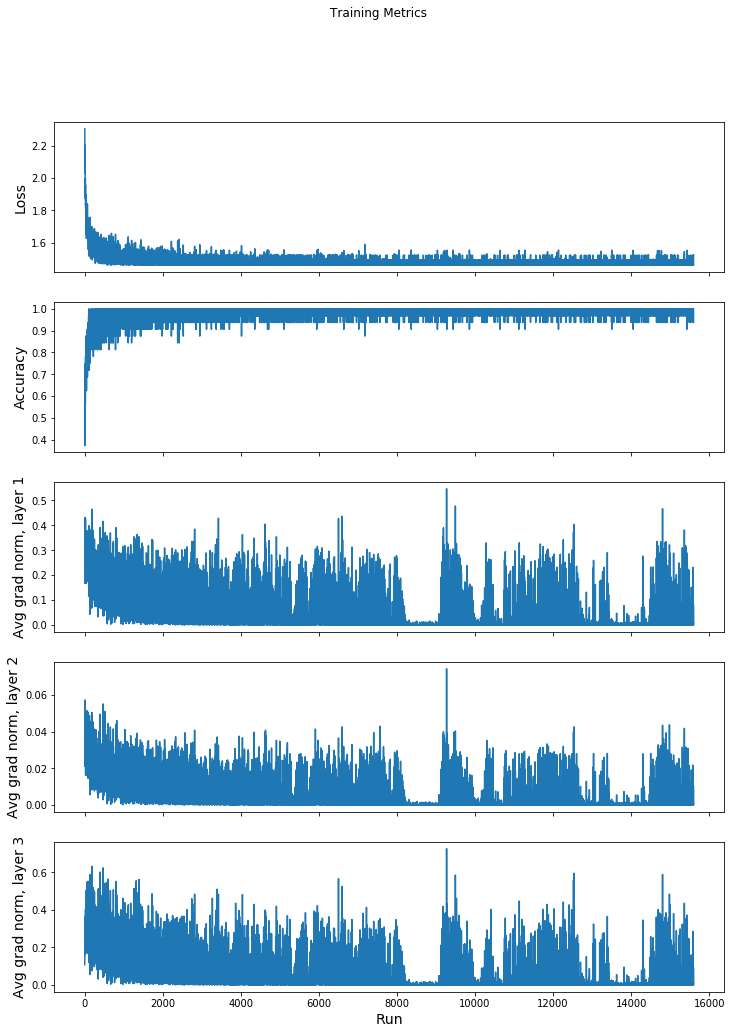

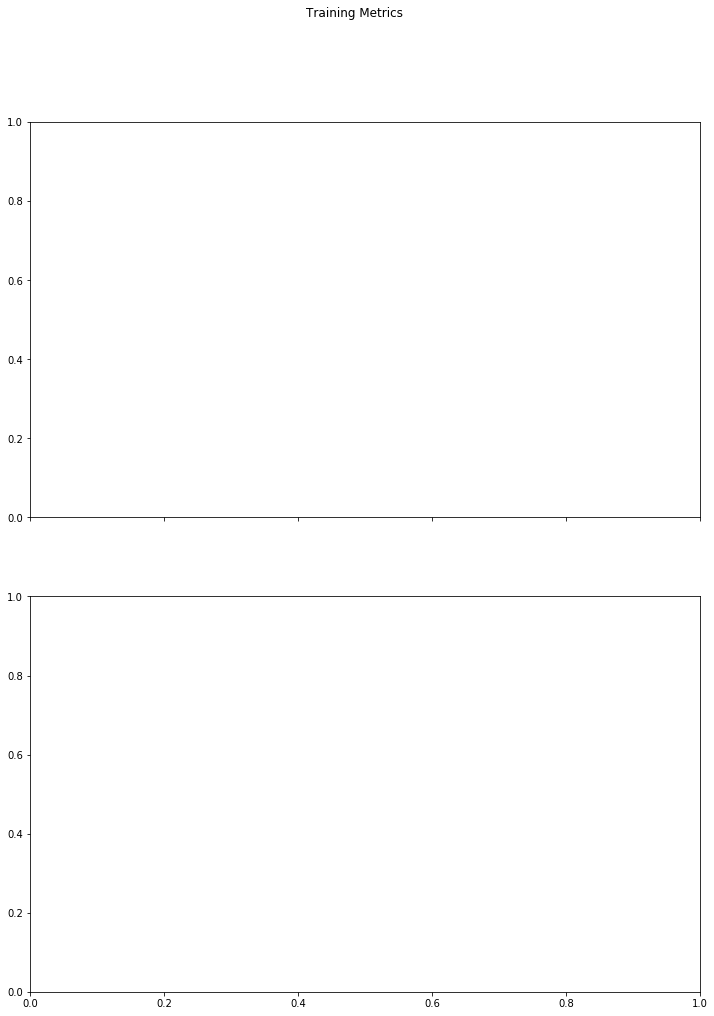

In [123]:
mnist_model.plot_metrics()

In [50]:
tfe = contrib.eager

train_loss_tape = []
train_accuracy_tape = []
train_grad_mags_tape = []
train_grad_avg_tape = []
train_lr_tape = []

n = x_train.shape[0]
batch_size = 32
learning_rate = 0.01

num_epochs = 50
num_iters = 200 #np.int(n/batch_size)

# regular training

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for run in range(num_iters):
        
        train_lr_tape.append(learning_rate)

        sample = np.random.randint(0, n-1, batch_size)
        x_batch = x_train[sample]
        y_batch = y_train[sample].astype(int)
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

        loss_value, grads = grad(model, x_batch, y_batch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

        grad_list = []
        for grad_ in grads:
            grad_norm = np.linalg.norm(grad_)
            grad_list.append(grad_norm)

        train_grad_mags_tape.append(grad_list)
        

    # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x_batch), axis=1, output_type=tf.int32), y_batch)
        
        learning_rate = learning_rate_update(learning_rate, epoch, num_epochs,)

  # end epoch
    train_loss_tape.append(epoch_loss_avg.result())
    train_accuracy_tape.append(epoch_accuracy.result())
    
    train_grad_avg_tape.append(np.mean(np.array(grad_list),axis=0))

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.591, Accuracy: 90.172%
Epoch 010: Loss: 1.582, Accuracy: 90.734%
Epoch 020: Loss: 1.571, Accuracy: 91.297%
Epoch 030: Loss: 1.567, Accuracy: 91.531%
Epoch 040: Loss: 1.560, Accuracy: 92.234%


In [51]:
len(train_grad_avg_tape)

50

In [7]:
def ensemble_model(num_individuals, x_train, y_train):

    
    model_list = []
    
    for i in range(num_individuals):
        
        model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
        
        
        train_loss_tape = []
        train_accuracy_tape = []
        train_grad_mags_tape = []
        train_grad_avg_tape = []
        train_lr_tape = []

        n = x_train.shape[0]
        batch_size = 32

        num_epochs = 201
        num_iters = 100 #np.int(n/batch_size)

        for epoch in range(num_epochs):
            epoch_loss_avg = tfe.metrics.Mean()
            epoch_accuracy = tfe.metrics.Accuracy()
            #epoch_grad_avg = tfe.metrics.Mean()

            for run in range(num_iters):

                sample = np.random.randint(0, n-1, batch_size)
                x_batch = x_train[sample]
                y_batch = y_train[sample].astype(int)

                loss_value, grads = grad(model, x_batch, y_batch)
                optimizer.apply_gradients(zip(grads, model.trainable_variables),
                                      global_step)

                grad_list = []
            
                for grad_ in grads:
                    grad_norm = np.linalg.norm(grad_)
                    grad_list.append(grad_norm)
                

                train_grad_mags_tape.append(grad_list)

            # Track progress
                epoch_loss_avg(loss_value)  # add current batch loss
            # compare predicted label to actual label
                epoch_accuracy(tf.argmax(model(x_batch), axis=1, output_type=tf.int32), y_batch)

          # end epoch
            train_loss_tape.append(epoch_loss_avg.result())
            train_accuracy_tape.append(epoch_accuracy.result())

            if epoch % 10 == 0:
                print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        epoch_loss_avg.result(),
                                                                        epoch_accuracy.result()))
                
        model_list.append(model)
    
    return model_list

In [8]:
def evaluate_ensemble(model_list, x_test, y_test):
    preds_list = [] 
    
    for model in model_list:
        preds = model.predict(x_test)
        preds_list.append(preds)
    
    ensemble_pred = np.mean(np.stack(preds_list),axis=0)

    label_pred = tf.math.argmax(ensemble_pred,axis=1)
    
    loss = tf.losses.softmax_cross_entropy(tf.one_hot(y_test,10), ensemble_pred)
    print("Loss: ", loss)
    
    accuracy = 1 - (np.sum(y_test == label_pred)/10000.0)
    print("Accuracy: ", accuracy)
    
    return loss, accuracy
    

In [30]:
len(train_grad_mags_tape)

20100

Text(0.5, 0, 'Epoch')

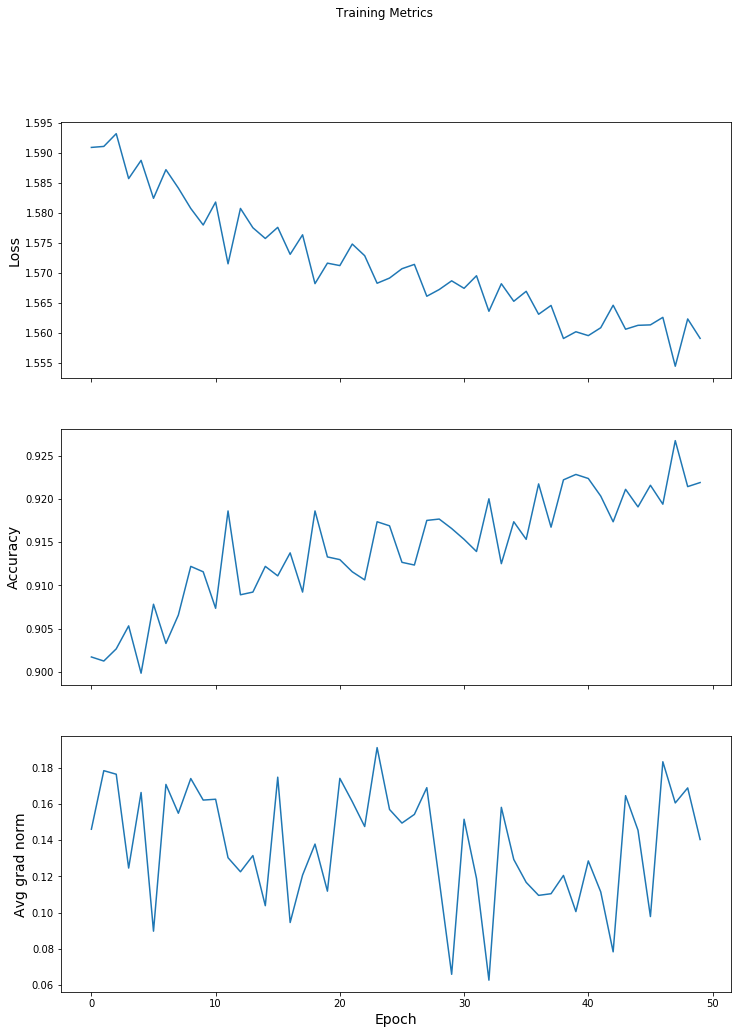

In [53]:
fig, axes = plt.subplots(3, sharex=True, figsize=(12, 16))
fig.suptitle('Training Metrics')


axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_tape)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].plot(train_accuracy_tape)

axes[2].set_ylabel("Avg grad norm",fontsize=14)
axes[2].plot(train_grad_avg_tape)
axes[2].set_xlabel("Epoch", fontsize=14)


In [38]:
np.array(train_grad_mags_tape)

array([[0.16106036, 0.01528806, 0.08831238, 0.01380959],
       [0.1805801 , 0.02055579, 0.1114336 , 0.0211546 ],
       [0.21019106, 0.02174203, 0.1288118 , 0.02027838],
       ...,
       [0.18555081, 0.02252272, 0.11214106, 0.01033466],
       [0.16333552, 0.01323302, 0.11830486, 0.00569167],
       [0.22679426, 0.0248042 , 0.15500352, 0.0110356 ]], dtype=float32)

Text(0.5, 0, 'Run')

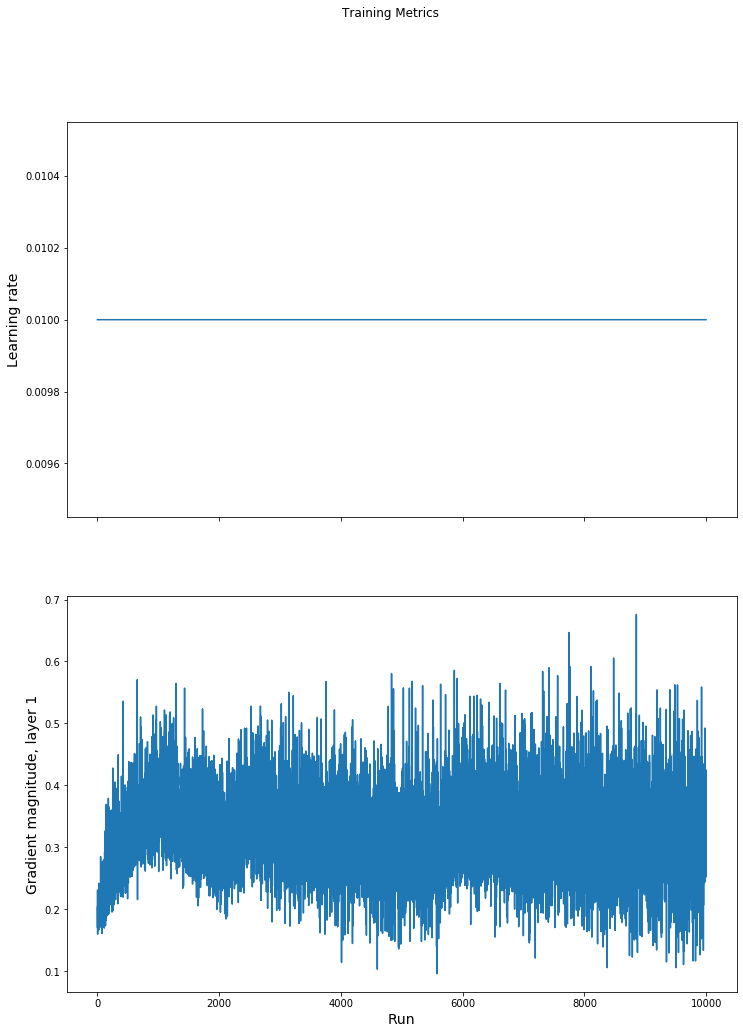

In [48]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 16))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Learning rate", fontsize=14)
axes[0].plot(train_lr_tape)

axes[1].set_ylabel("Gradient magnitude, layer 1", fontsize=14)
axes[1].plot(np.array(train_grad_mags_tape)[:,0])
axes[1].set_xlabel("Run", fontsize=14)

Text(0.5, 0, 'Run')

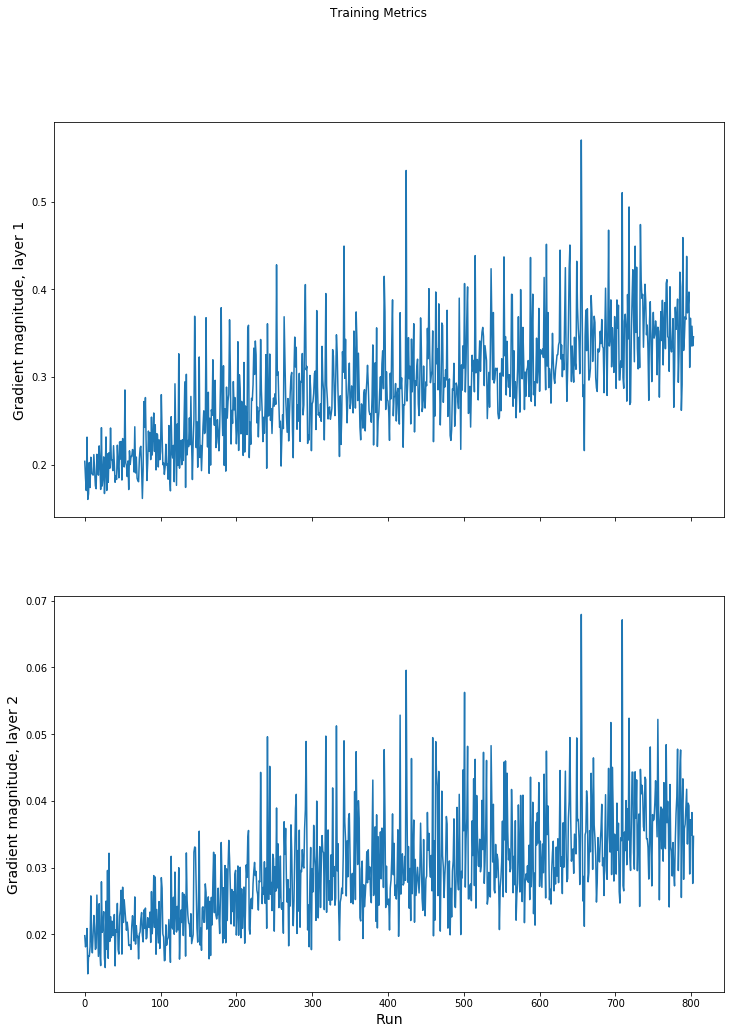

In [49]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 16))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Gradient magnitude, layer 1", fontsize=14)
axes[0].plot(np.array(train_grad_mags_tape)[:201*4,0])

axes[1].set_ylabel("Gradient magnitude, layer 2", fontsize=14)
axes[1].plot(np.array(train_grad_mags_tape)[:201*4,1])

axes[1].set_xlabel("Run", fontsize=14)

In [9]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

NameError: name 'test_dataset' is not defined

In [14]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

NameError: name 'class_names' is not defined

In [6]:
# high-level Keras model

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

11493376/11490434 [==============================] - 56s 5us/step


W0619 13:07:04.153959 4345886144 deprecation.py:323] From /Users/lsorense/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
60000/60000 [==============================] - 8s 130us/sample - loss: 0.2216 - acc: 0.9346
Epoch 2/5
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0949 - acc: 0.9711
Epoch 3/5
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0690 - acc: 0.9784
Epoch 4/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0535 - acc: 0.9827
Epoch 5/5
10000/10000 [==============================] - 0s 43us/sample - loss: 0.0581 - acc: 0.9821


[0.0581096921046963, 0.9821]

In [ ]:
# high-level Keras model in loop

num_models = 5
models = []

for i in range(num_models):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5)
    models.append(model)

In [50]:
def evaluate_ensemble(model_list, x_test, y_test):
    preds_list = [] 
    
    for model in model_list:
        preds = model.predict(x_test)
        #print(preds)
        preds_list.append(preds)
    
    print("y_test shape:", y_test.shape)
    ensemble_pred = np.mean(np.stack(preds_list),axis=0)
    #print(ensemble_pred)
    print("Ensemble pred shape:", ensemble_pred.shape)
    label_pred = tf.math.argmax(ensemble_pred,axis=1)
    print(label_pred)
    loss = tf.losses.softmax_cross_entropy(tf.one_hot(y_test,10), ensemble_pred)
    print("Loss: ", loss)
    accuracy = 1 - (np.sum(y_test == label_pred)/10000)
    #accuracy = tf.keras.metrics.sparse_categorical_crossentropy(y_test, label_pred)
    print("Accuracy: ", accuracy)
    return ensemble_pred
    
    # TODO: find catgorical loss 
    
#model.evaluate(x_test, y_test)

evaluate_ensemble(models, x_test, y_test)

y_test shape: (10000,)
Ensemble pred shape: (10000, 10)
tf.Tensor([7 2 1 ... 4 5 6], shape=(10000,), dtype=int64)
Loss:  tf.Tensor(1.4850203, shape=(), dtype=float32)
Accuracy:  1.0


array([[1.9896795e-09, 2.4574625e-09, 1.5480719e-08, ..., 9.9998075e-01,
        9.6531094e-09, 2.8743189e-06],
       [2.8822966e-09, 1.7037626e-06, 9.9999809e-01, ..., 4.4510084e-14,
        6.5817190e-08, 4.4665001e-13],
       [1.6269691e-08, 9.9991024e-01, 1.6426715e-05, ..., 4.6757901e-05,
        1.5032619e-05, 8.1201776e-08],
       ...,
       [1.0836306e-13, 1.7991258e-09, 3.0248940e-13, ..., 3.5904482e-06,
        6.2107951e-08, 4.9836159e-05],
       [2.5203140e-09, 2.8284572e-10, 5.7193634e-12, ..., 5.8851000e-09,
        9.3742536e-04, 1.8913093e-11],
       [1.0471130e-09, 1.4950366e-11, 2.4768034e-09, ..., 6.6273023e-14,
        8.4541718e-10, 5.9797245e-12]], dtype=float32)

In [8]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(784, 512) dtype=float32, numpy=
 array([[-0.05439534,  0.05405951,  0.05244584, ..., -0.05085037,
         -0.00760539,  0.05373384],
        [-0.01471039,  0.00141557,  0.02652072, ..., -0.00676998,
         -0.000292  ,  0.05190373],
        [-0.01387183, -0.00507368,  0.06086038, ...,  0.05619719,
         -0.05137127,  0.04644447],
        ...,
        [ 0.03309014,  0.01011394,  0.05528155, ..., -0.05871866,
          0.06492488,  0.03704452],
        [-0.00773048,  0.06440836,  0.00720786, ..., -0.04319189,
          0.01425928,  0.01923797],
        [-0.01121531,  0.00569782,  0.02268732, ...,  0.04061238,
          0.05151873, -0.0065253 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32, numpy=
 array([-6.15850501e-02,  7.78719177e-03, -2.81438287e-02,  2.35707052e-02,
         9.51044634e-02,  2.75625326e-02, -4.00929200e-03,  1.96834486e-02,
        -2.51014549e-02,  2.95076836e-02,  4.05867696e-02, -8.34866893e